#### Учебный проект в рамках профессии Data Science Яндекс.Практикума

# Описание задачи

Подготовим прототип модели машинного обучения. 

Наша модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


# 1. Подготовка данных

In [3]:
# Импортируем необходимые библиотеки

import pandas as pd
import numpy as np
from scipy import stats as st

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error, accuracy_score, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [4]:
# Загрузим файлы

df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full.csv')


In [5]:
# Напишем функцию для подробного изучения данных

def display_info(data):
    print(data.head(5))
    print(data.info())
    print(data.describe())
    pass

In [6]:
# Посмотрим на обучающую выборку

display_info(df_train)

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

In [7]:
# Посмотрим на тестовую выборку

display_info(df_test)

                  date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469                             1398.777

Как и было ожидаемо из условий задания в тестовой выборке гораздо меньше данных и столбцов. О них мы поговорим подробнее чуть позже.

In [6]:
# Посмотрим на исходные данные

display_info(df_full)

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

<AxesSubplot:>

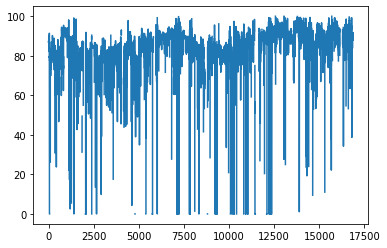

In [8]:
# Посмотрим на динамику значений по эффективности обогащения чернового концентрата на обучающей выборке

df_train['rougher.output.recovery'].plot()

<AxesSubplot:>

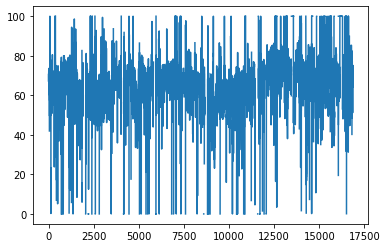

In [9]:
# Посмотрим на динамику значений по эффективности обогащения финального концентрата на обучающей выборке

df_train['final.output.recovery'].plot()

Увидели, что на финальном концентрате значения сместились вниз по шкале, что скорее всего говорит о том, что в процессе мы потеряли какой-то объем материалов в виде отвальных хвостов и это нормально.

In [10]:
# Посмотрим есть ли пропуски и в каких данных 

def find_na(data):
    na_count = data.isna().sum()
    return na_count

In [11]:
print('Пропуски в обучающей выборке')
find_na(df_train)

Пропуски в обучающей выборке


date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

In [12]:
print('Пропуски в тестовой выборке')
find_na(df_test)

Пропуски в тестовой выборке


date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [12]:
print('Пропуски в исходных данных')
find_na(df_full)

Пропуски в исходных данных


date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

Во всех датасетах есть какое-то количество пропусков. Для общего объема датасетов это не такие большие данные, мы можем ими пожертвовать.

In [13]:
# Можно удалить пробелы в train

df_train.dropna(subset = ['rougher.output.recovery'],inplace = True)

In [14]:
c = df_train['rougher.output.concentrate_au']
f = df_train['rougher.input.feed_au']
t = df_train['rougher.output.tail_au'] 

df_train['rougher_output_recovery_est'] = (c * (f - t)) / (f * (c - t)) * 100

In [15]:
mean_absolute_error(df_train['rougher.output.recovery'], df_train['rougher_output_recovery_est'])

9.444891926100695e-15

Среднеквадратичная ошибка показывает 9, что все же не очень хороший результат. <br>

Возможно, что-то еще влияет на результаты выделения концентратов или же у нас есть много выбросов, которые влияют на качество расчетов. 

In [16]:
# Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

Мы знаем, что  в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков. Рассмотрим какие признаки отличаются: 

In [16]:
print('Количество столбцов в исходных данных:',len(df_full.columns))
print('Количество столбцов в обучающей выборке:', len(df_train.columns))
print('Количество столбцов в тестовой выборке:',len(df_test.columns))

train_columns = df_train.columns
test_columns = df_test.columns
print('- - -')
print('Найдем отличающиеся столбцы:',set(train_columns).difference(test_columns))

Количество столбцов в исходных данных: 87
Количество столбцов в обучающей выборке: 88
Количество столбцов в тестовой выборке: 53
- - -
Найдем отличающиеся столбцы: {'primary_cleaner.output.concentrate_ag', 'rougher.output.tail_au', 'rougher.output.concentrate_au', 'secondary_cleaner.output.tail_sol', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.tail_ag', 'rougher_output_recovery_est', 'rougher.output.tail_sol', 'rougher.output.tail_pb', 'primary_cleaner.output.tail_ag', 'final.output.tail_au', 'final.output.tail_pb', 'rougher.output.tail_ag', 'secondary_cleaner.output.tail_pb', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'final.output.concentrate_ag', 'secondary_cleaner.output.tail_ag', 'primary_cleaner.output.concentrate_au', 'secondary_cleaner.output.tail_au', 'rougher.output.recovery', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentra

Мы знаем, что меньше всего параметров в тестовой выборке и там не хватает достаточно много данных по процессу очистки. Судя по списку, данные выпадают на каждом этапе анализа, поэтому полноценной работы без них не получится.
Вместе с тем, мы видим, что данные есть в нашей исходной выборке. Возьмем их оттуда.

In [17]:
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')

In [18]:
# Убедимся что наши данные очистились

df_train.info()
df_test.info()
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14287 entries, 0 to 16859
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14287 non-null  object 
 1   final.output.concentrate_ag                         14287 non-null  float64
 2   final.output.concentrate_pb                         14287 non-null  float64
 3   final.output.concentrate_sol                        14287 non-null  float64
 4   final.output.concentrate_au                         14287 non-null  float64
 5   final.output.recovery                               14287 non-null  float64
 6   final.output.tail_ag                                14287 non-null  float64
 7   final.output.tail_pb                                14287 non-null  float64
 8   final.output.tail_sol                               14287 non-null  float64


**Выводы**

Мы провели предварительный анализ данных: посмотрели на наши строки, различия в датасетах, посмотрели на визуализацию объемов материалов на черновом концентрате и на финальном, убедились, что часть материалов уходит с отвальными хвостами.

В ходе анализа мы увидели, что наши выборки отличаются не только по размерам, но и по признакам. Исходный датасет содержит обучающую и тестовую выборки со всеми признаками. Поэтому для нас важнее посмотреть на различия между тестовой и обучающей.

В тестовой выборке, в отличие от обучающей недостает 35 столбцов, которые говорят о результатах очистки (они содержат данные об отвальных хвостах и состоянии материалов после обработки, и, что самое важное, об эффективности обогащения чернового и финального концентрата). В тестовой выборке у нас по сути остается только input, т.е. параметры сырья.

Во всех датасетах были обнаружены мелкие погрешности в виде пропусков, na были заменены на пропуски, чтобы не допускать ошибок в дальнейших вычислениях.

# 2. Анализ данных

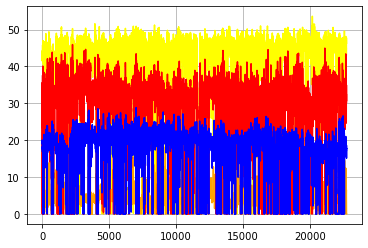

In [19]:
# Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишем выводы.

def show_concentration(element, rougher, primary, secondary, final):
    df_full[final].plot(grid=True, color = 'yellow')
    df_full[secondary].plot(grid=True, color = 'orange')
    df_full[primary].plot(grid=True, color = 'red')
    df_full[rougher].plot(grid=True, color = 'blue')
    pass

show_concentration('au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'secondary_cleaner.output.tail_au', 'final.output.concentrate_au' ) 

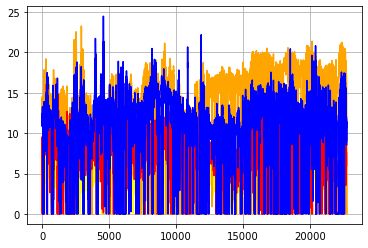

In [20]:
show_concentration('ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'secondary_cleaner.output.tail_ag', 'final.output.concentrate_ag' )

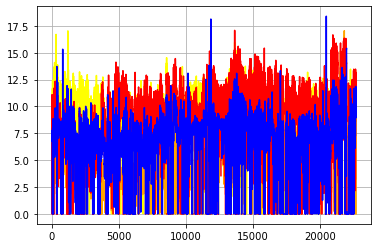

In [21]:
show_concentration('pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'secondary_cleaner.output.tail_pb', 'final.output.concentrate_pb' )

Визуализация наглядно показывает как движется процесс обработки материалов.<br>

На примере **золота** мы видим как изменение в динамике параметров равномерно приводят к очистке исходного сырья и в финале концентрация становится в два раза больше, чем раньше. В виде отвальных хвостов, видимо, уходит половина исходного сырья.<br>
На примере **серебра** уже не все так очевидно. Лучшая концентрация видна при повторной очистке, но не в финальном концентрате. Возможно в ходе очистки теряются какие-то нужные ресурсы? <br>
Со **свинцом** ситуация по обработке сырья похожа на процесс с золотом, правда не так явно. Самая высокая концентрация видна на на финальной стадии, ее почти догоняют результаты первичной обработки.<br>

Данные распределены довольно равномерно, на этой стадии аномалий или выбросов не видно.

In [22]:
# Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 
# Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

def show_spread(element, column):
    df_train[column].plot(kind = 'hist', grid=True, color = 'blue')
    df_test[column].plot(kind = 'hist', grid=True, color = 'green')
    pass
                             

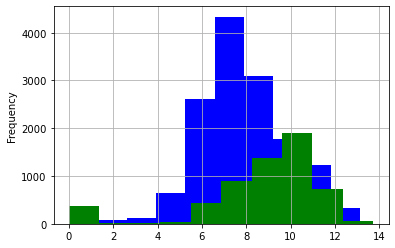

In [23]:
show_spread('au', 'rougher.input.feed_au')

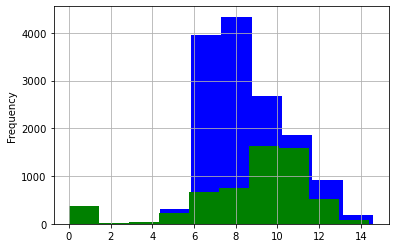

In [24]:
show_spread('ag', 'rougher.input.feed_ag')

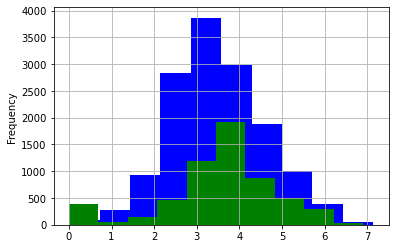

In [25]:
show_spread('pb', 'rougher.input.feed_pb')

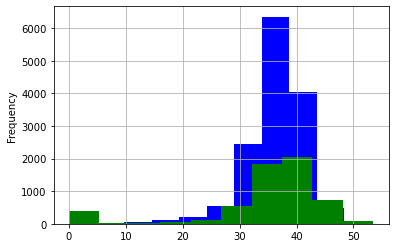

In [26]:
show_spread('sol', 'rougher.input.feed_sol')

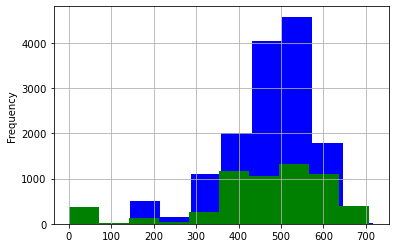

In [27]:
show_spread('rate', 'rougher.input.feed_rate')

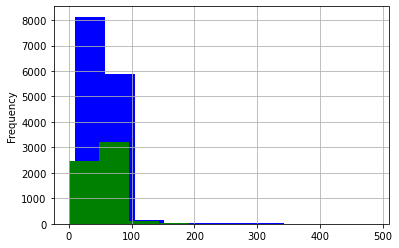

In [28]:
show_spread('size', 'rougher.input.feed_size')

**Промежуточные выводы** Распределения не очень сильно отличаются, но одно важное отличие все-таки есть: на тестовой выборке очень много значений около нуля. Чтобы это не мешало нашим прогнозам, уберем все нули из выборки. Благодаря подсказке узнала, что это ошибка оборудования :)

In [29]:
df_full_5_bar = df_full[(df_full['rougher.input.feed_au'] > 5) & (df_full['rougher.input.feed_ag'] > 5) & (df_full['rougher.input.feed_pb'] > 5) & (df_full['rougher.input.feed_pb'] > 5) & (df_full['rougher.input.feed_sol'] > 5) & (df_full['rougher.input.feed_size']  > 5)& (df_full['rougher.input.feed_rate']  > 5)]

In [30]:
df_train_5_bar = df_train[(df_train['rougher.input.feed_au'] > 5) & (df_train['rougher.input.feed_ag'] > 5) & (df_train['rougher.input.feed_pb']> 5) & (df_train['rougher.input.feed_pb']> 5) & (df_train['rougher.input.feed_sol'] > 5) & (df_train['rougher.input.feed_size']  > 5)& (df_train['rougher.input.feed_rate']  > 5)]

In [31]:
df_test_5_bar = df_test[(df_test['rougher.input.feed_au'] > 5) & (df_test['rougher.input.feed_ag'] > 5) & (df_test['rougher.input.feed_pb'] > 5) & (df_test['rougher.input.feed_pb'] > 5) & (df_test['rougher.input.feed_sol'] > 5) & (df_test['rougher.input.feed_size']  > 5)& (df_test['rougher.input.feed_rate']  > 5)]

In [32]:
# Выборочно проверим изменились ли наши минимумы

print(df_train_5_bar['rougher.input.feed_au'].min())
print(df_full_5_bar['rougher.input.feed_sol'].min())
print(df_test_5_bar['rougher.input.feed_pb'].min())

5.3256562063745525
7.99168253980577
5.001801859935124


In [33]:
def show_spread_5_bar(element, column):
    df_train_5_bar[column].plot(kind = 'hist', grid=True, color = 'blue')
    df_test_5_bar[column].plot(kind = 'hist', grid=True, color = 'green')
    pass
              

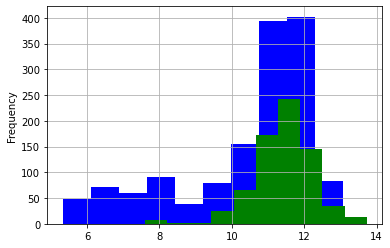

In [34]:
# Посмотрим еще раз как выглядит распределение между выборками теперь (на примере золота и свинца):

show_spread_5_bar('au', 'rougher.input.feed_au')

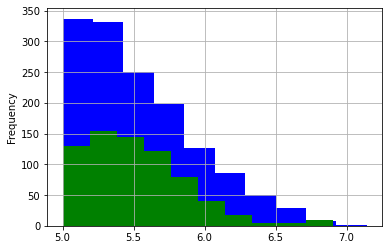

In [35]:
show_spread_5_bar('pb', 'rougher.input.feed_pb')

**Промежуточные выводы:** Снова нельзя сказать, что данные абсолютно идентичны, но теперь нет аномальных выбросов, а значит и данные для построения и тестирования модели у нас намного более качественные

rougher


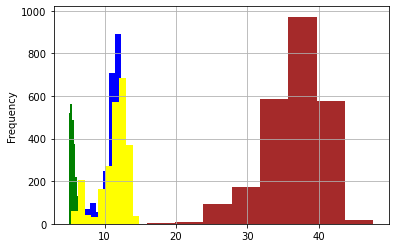

In [36]:
# Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 
# Заметили аномальные значения в суммарном распределении или нет? 
# Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

def show_sum(stage, au, ag, pb, sol):
    print(stage)
    df_full_5_bar[au].plot(kind = 'hist', grid=True, color = 'blue')
    df_full_5_bar[pb].plot(kind = 'hist', grid=True, color = 'green')
    df_full_5_bar[sol].plot(kind = 'hist', grid=True, color = 'brown')
    df_full_5_bar[ag].plot(kind = 'hist', grid=True, color = 'yellow')
    pass

show_sum('rougher', 'rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol')

primary


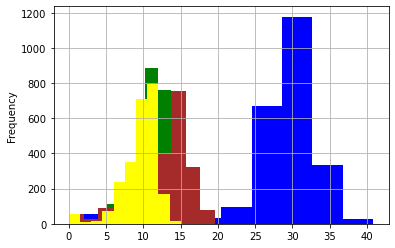

In [37]:
show_sum('primary', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol')

final


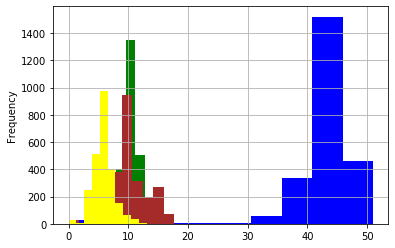

In [39]:
show_sum('final', 'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol')

**Выводы:** <br>
Благодаря визуализации мы можем наблюдать как происходит процесс выделения золота (синее на графиках) на разных стадиях обработки сырья: сначала оно смешано с остальным сырьем, далее работают процессы очищения и концентрация золота явно возрастает. сразу стало заметно, что процесс работает эффективно.

На этом этапе мы также нашли аномальные выбросы из-за которых тестовые и обучающие выборки сильно разнились. Чтобы исправить ошибку измерительных материалов мы возьмем в наши датасеты только те исходные величины по сырью, которые больше 5, чтобы не обрабатывать строки с ошибочными нулями.

Этот фактор мог очень сильно повлиять на качество нашей модели, но теперь он устранен и можно приступать к разработке предсказаний.

# 3. Модель

Обучим разные модели и оценим их качество кросс-валидацией. 
Выберем лучшую модель и проверьте её на тестовой выборке. Опишем выводы

In [39]:
#Шаг1 формула
def sMAPE(target, predictions):
    smape = (abs(np.array(target)-predictions))/(abs(np.array(target)+abs(predictions)) /2)*100
    smape_roughter = smape[:,0].sum()/target.shape[0]
    smape_final = smape[:,1].sum()/target.shape[0]
    smape_total = 0.25*smape_roughter + 0.75*smape_final
    return smape_total

In [40]:
# На всякий случай загружаю чистые исходные данные, чтобы сбить предыдущие отсечки

df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full.csv')

In [41]:
df_train = df_train.replace([np.inf, -np.inf], np.nan)
df_test = df_test.replace([np.inf, -np.inf], np.nan)
df_full = df_full.replace([np.inf, -np.inf], np.nan)

In [42]:
# Добавим в df_test целевые признаки 'rougher.output.recovery' и 'final.output.recovery' из таблицы df_full

df_test = df_test.merge(df_full[['rougher.output.recovery', 'final.output.recovery','date']], on='date', how='left')

In [43]:
# Удалим дубликаты из датасетов и уберем нулевые output-ы, т.к. они вероятно плод ошибки исходных данных

df_test = df_test[(df_test['rougher.output.recovery'] != 0) & (df_test['final.output.recovery'] != 0)]
df_test = df_test.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
df_train = df_train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
df_train = df_train[(df_train['rougher.output.recovery'] != 0) & (df_train['final.output.recovery'] != 0)]

df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()
df_full = df_full.drop_duplicates()

In [44]:
# Заполним пропуски предыдущим значением

df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')

In [45]:
# Уберем нулевые значения, но оставим все больше 0.1, чтобы наши расчеты были близки к реальности

In [46]:
df_full = df_full[(df_full['rougher.input.feed_au'] > 0.1) & (df_full['rougher.input.feed_ag'] > 0.1) & (df_full['rougher.input.feed_pb'] > 0.1) & (df_full['rougher.input.feed_pb'] > 0.1) & (df_full['rougher.input.feed_sol'] > 0.1) & (df_full['rougher.input.feed_size']  > 0.1)& (df_full['rougher.input.feed_rate']  >0.1)]

In [47]:
df_train = df_train[(df_train['rougher.input.feed_au'] > 0.1) & (df_train['rougher.input.feed_ag'] > 0.1) & (df_train['rougher.input.feed_pb']> 0.1) & (df_train['rougher.input.feed_pb']> 0.1) & (df_train['rougher.input.feed_sol'] > 0.1) & (df_train['rougher.input.feed_size']  > 0.1)& (df_train['rougher.input.feed_rate']  > 0.1)]

In [48]:
df_test = df_test[(df_test['rougher.input.feed_au'] > 0.1) & (df_test['rougher.input.feed_ag'] > 0.1) & (df_test['rougher.input.feed_pb'] > 0.1) & (df_test['rougher.input.feed_pb'] > 0.1) & (df_test['rougher.input.feed_sol'] > 0.1) & (df_test['rougher.input.feed_size']  > 0.1)& (df_test['rougher.input.feed_rate']  > 0.1)]

In [49]:
# Убедимся, что у нас нет нулей
print(df_test.isnull().sum())
print(df_train.isnull().sum())

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [50]:
# Сравним столбцы в обучающем и тестовом датафрейме, приведем их к единому виду
different_columns = set(df_train.columns).difference(df_test.columns)
print('Найдем отличающиеся столбцы:', different_columns)
print(len(df_train.columns))
print(len(df_test.columns))


Найдем отличающиеся столбцы: {'primary_cleaner.output.concentrate_ag', 'rougher.output.tail_au', 'rougher.output.concentrate_au', 'secondary_cleaner.output.tail_sol', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.tail_ag', 'rougher.output.tail_sol', 'rougher.output.tail_pb', 'primary_cleaner.output.tail_ag', 'final.output.tail_au', 'final.output.tail_pb', 'rougher.output.tail_ag', 'secondary_cleaner.output.tail_pb', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'final.output.concentrate_ag', 'secondary_cleaner.output.tail_ag', 'primary_cleaner.output.concentrate_au', 'secondary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_pb', 'final.output.tail_sol', 'rougher.output.concentrate_sol', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'primary_cleaner.output.tail_au', 'rougher.calculation.au_pb_ratio', 'pr

In [53]:
same_columns =  set(df_train.columns).intersection(df_test.columns)
print('Найдем одинаковые столбцы:', same_columns)
print('Найдем количество одинаковых столбцов:', len(same_columns))

Найдем одинаковые столбцы: {'primary_cleaner.state.floatbank8_b_level', 'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank4_b_level', 'rougher.state.floatbank10_d_air', 'secondary_cleaner.state.floatbank3_a_air', 'date', 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.input.depressant', 'rougher.input.feed_sol', 'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_f_level', 'secondary_cleaner.state.floatbank2_a_level', 'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank5_a_air', 'rougher.state.floatbank10_e_level', 'primary_cleaner.state.floatbank8_d_level', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_d_level', 'primary_cleaner.input.feed_size', 'primary_cleaner.state.floatbank8_c_level', 'secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank4_a_air', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_f_air', 'sec

In [51]:
# Соберем датафреймы из одинаковых колонок

In [52]:
df_train_new = df_train[['date', 'rougher.state.floatbank10_f_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.input.feed_sol', 'primary_cleaner.input.xanthate', 'rougher.input.feed_au', 'secondary_cleaner.state.floatbank3_a_air', 'rougher.input.feed_pb', 'rougher.state.floatbank10_f_air', 'primary_cleaner.state.floatbank8_d_air', 'rougher.input.floatbank10_xanthate', 'primary_cleaner.state.floatbank8_a_air', 'secondary_cleaner.state.floatbank2_b_air', 'rougher.state.floatbank10_d_level', 'secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank4_b_air', 'primary_cleaner.input.feed_size', 'primary_cleaner.state.floatbank8_a_level', 'rougher.state.floatbank10_a_air', 'secondary_cleaner.state.floatbank3_b_level', 'rougher.state.floatbank10_c_level', 'secondary_cleaner.state.floatbank4_a_air', 'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.input.depressant', 'secondary_cleaner.state.floatbank4_a_level', 'rougher.state.floatbank10_e_level', 'rougher.input.floatbank11_sulfate', 'rougher.state.floatbank10_a_level', 'secondary_cleaner.state.floatbank3_a_level', 'primary_cleaner.input.sulfate', 'secondary_cleaner.state.floatbank6_a_air', 'primary_cleaner.state.floatbank8_b_level', 'secondary_cleaner.state.floatbank4_b_level', 'rougher.output.recovery', 'primary_cleaner.state.floatbank8_d_level', 'rougher.input.floatbank11_xanthate', 'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank5_b_air', 'rougher.input.feed_size', 'rougher.state.floatbank10_e_air', 'rougher.input.feed_rate', 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_b_air', 'secondary_cleaner.state.floatbank2_b_level', 'rougher.input.feed_ag', 'secondary_cleaner.state.floatbank5_a_level', 'rougher.state.floatbank10_d_air', 'secondary_cleaner.state.floatbank2_a_level', 'rougher.state.floatbank10_c_air', 'rougher.input.floatbank10_sulfate', 'final.output.recovery', 'secondary_cleaner.state.floatbank5_b_level', 'secondary_cleaner.state.floatbank6_a_level']]

In [53]:
df_test_new = df_test[['date', 'rougher.state.floatbank10_f_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.input.feed_sol', 'primary_cleaner.input.xanthate', 'rougher.input.feed_au', 'secondary_cleaner.state.floatbank3_a_air', 'rougher.input.feed_pb', 'rougher.state.floatbank10_f_air', 'primary_cleaner.state.floatbank8_d_air', 'rougher.input.floatbank10_xanthate', 'primary_cleaner.state.floatbank8_a_air', 'secondary_cleaner.state.floatbank2_b_air', 'rougher.state.floatbank10_d_level', 'secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank4_b_air', 'primary_cleaner.input.feed_size', 'primary_cleaner.state.floatbank8_a_level', 'rougher.state.floatbank10_a_air', 'secondary_cleaner.state.floatbank3_b_level', 'rougher.state.floatbank10_c_level', 'secondary_cleaner.state.floatbank4_a_air', 'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.input.depressant', 'secondary_cleaner.state.floatbank4_a_level', 'rougher.state.floatbank10_e_level', 'rougher.input.floatbank11_sulfate', 'rougher.state.floatbank10_a_level', 'secondary_cleaner.state.floatbank3_a_level', 'primary_cleaner.input.sulfate', 'secondary_cleaner.state.floatbank6_a_air', 'primary_cleaner.state.floatbank8_b_level', 'secondary_cleaner.state.floatbank4_b_level', 'rougher.output.recovery', 'primary_cleaner.state.floatbank8_d_level', 'rougher.input.floatbank11_xanthate', 'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank5_b_air', 'rougher.input.feed_size', 'rougher.state.floatbank10_e_air', 'rougher.input.feed_rate', 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_b_air', 'secondary_cleaner.state.floatbank2_b_level', 'rougher.input.feed_ag', 'secondary_cleaner.state.floatbank5_a_level', 'rougher.state.floatbank10_d_air', 'secondary_cleaner.state.floatbank2_a_level', 'rougher.state.floatbank10_c_air', 'rougher.input.floatbank10_sulfate', 'final.output.recovery', 'secondary_cleaner.state.floatbank5_b_level', 'secondary_cleaner.state.floatbank6_a_level']]

In [54]:
# Убедимся, что у них тепреь одинаковый размер

print(len(df_test_new.columns))
print(len(df_train_new.columns))

55
55


In [55]:
# Удаляем лишние столбцы

df_test_new = df_test_new.drop('date', axis = 1)
df_train_new = df_train_new.drop('date', axis = 1)

In [56]:
# Выделяем признаки

features = df_test_new.columns.values

In [57]:
# выделяем целевые
targets = ['rougher.output.recovery', 'final.output.recovery']

In [58]:
# обучение
features_train = df_train_new[features].reset_index(drop=True)
target_train = df_train_new[targets].reset_index(drop=True)

In [59]:
# тест
features_test = df_test_new[features].reset_index(drop=True)
target_test = df_test_new[targets].reset_index(drop=True)

### Обучение линейной регрессии

In [60]:
regression_model = LinearRegression()
sMAPE_score = cross_val_score(regression_model,features_train, target_train, cv=5, scoring=make_scorer(sMAPE))
sMAPE_score.mean()

3.6199772644508305e-14

### Обучение дерева

In [61]:
forest_model = RandomForestRegressor(max_depth=8, random_state=42)
sMAPE_score = cross_val_score(forest_model, features_train, target_train, cv=5, scoring=make_scorer(sMAPE))
sMAPE_score.mean()

0.49871857968594374

In [62]:
decision_tree_model = DecisionTreeRegressor(max_depth=8, random_state=42)
sMAPE_score = cross_val_score(decision_tree_model, features_train, target_train, cv=5, scoring=make_scorer(sMAPE))
sMAPE_score.mean()

1.1527075029771945

### Ридж регрессия

In [69]:
ridge_model = Ridge()
sMAPE_score = cross_val_score(ridge_model,features_train, target_train, cv=5, scoring=make_scorer(sMAPE))
sMAPE_score.mean()

2.5943395305798416e-05

### Лассо модель

In [73]:
lasso_model = Lasso()
sMAPE_score = cross_val_score(lasso_model,features_train, target_train, cv=5, scoring=make_scorer(sMAPE))
sMAPE_score.mean()

0.16967188868950145

### Использование лучшей модели (или regression_model или forest_model) на тестовой выборке

Возьмем модели, которые показали у нас наилучшие результаты: Случайный лес и Лассо

In [74]:
lasso_model = Lasso()
sMAPE_score = cross_val_score(lasso_model,features_test, target_test, cv=5, scoring=make_scorer(sMAPE))
sMAPE_score.mean()

0.1768518397704846

In [75]:
forest_model = RandomForestRegressor(max_depth=8, random_state=42)
sMAPE_score = cross_val_score(forest_model, features_test, target_test, cv=5, scoring=make_scorer(sMAPE))
sMAPE_score.mean()

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

0.6419025423181606

In [ ]:
out['rougher.output.recovery.median'] = model1_Y_train.median()
out['final.output.recovery.median'] = model2_Y_train.median()
out.columns = ['rougher.recovery', 'final.recovery', 'rougher.recovery.predicted', 
               'final.recovery.predicted', 'rougher.recovery.median', 'final.recovery.median']
out

final_sMAPE = 0.25 * sMAPE_score(out['rougher.recovery'], out['rougher.recovery.median'])
final_sMAPE += 0.75 * sMAPE_score(out['final.recovery'], out['final.recovery.median'])
final_sMAPE


### Выводы

Мы использовали регрессионные модели, так как они лучше всего подходят для анализа взаимосвязей нескольких целевых признаков. Лучше всего себя показала (т.е. с меньшей ошибкой) модель линейной регрессии.

Добавила к лесу, деревьям и линейной еще две регрессии - Ridge и Lasso. Судя по цифрам Lasso оказалась удачнее: возможно дело в том, что она хорошо справляется с мультиколлинеарностью параметров и в ней заложена регуляризация множества взаимозависимых параметров. Судя по нашему технологическому процессу у нас именно такой кейс, химические элементы и кусочки процесса не могут не влиять друг на друга.
На тесте наши результаты показались чуть хуже, чем на обучающей выборке, при этом не очень далеко ушли от нее, значит модели и данные были выбраны корректно.